In [1]:
from data_processing import *
from model_training import *
import glob
import math
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import warnings
from os import path
warnings.filterwarnings("ignore")

In [2]:
columns = pd.read_csv('data/columns.txt', header=None)
columns_list = columns.transpose().values.tolist()[0]

sensors = ['lJPos', 'rJPos', 'lJVel',
           'rJVel', 'gyroX', 'gyroY', 'gyroZ', 'accX',
           'accY', 'accZ']

mode_pool = ['L0R0']
trial_pool = [1, 2, 3, 4, 5]
data_all = []

data_dir = 'data/'
for mode in mode_pool:
    for trial in trial_pool:
        file_path = data_dir+'log_'+str(mode)+'_'+str(trial)+'.txt'
        if path.exists(file_path) == 1:
            for read_path in glob.glob(file_path):
                data = pd.read_csv(read_path, sep=" ", header=None)
                data = data.iloc[:,0:15]
                data.columns = columns_list
                data = data[sensors]
                data_all.append(data)


In [3]:
data_list = label_data(data_all)

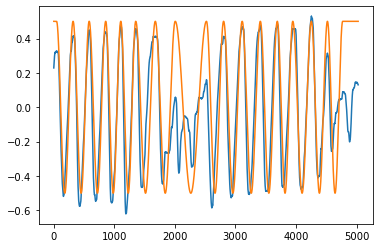

In [23]:
plt.plot(data_list[4]['rJPos'])
# plt.plot(data_list[4]['rJPos'])
plt.plot(data_list[4]['rightGaitPhaseX']/2)
plt.show()


# plt.plot(data_list[4]['leftGaitPhaseY'])
# plt.show()

In [4]:
data_list[4]

,lJPos,rJPos,lJVel,rJVel,gyroX,gyroY,gyroZ,accX,accY,accZ,leftGaitPhaseX,leftGaitPhaseY,rightGaitPhaseX,rightGaitPhaseY
0,-0.125794,0.228961,-0.053513,1.313077,0.123025,0.463575,-0.327775,1.3524,-9.907800,0.9702,1.0,0.0,1.0,0.0
1,-0.126945,0.235480,-0.105402,1.324056,0.072800,0.427350,-0.274400,0.9898,-9.241400,0.7840,1.0,0.0,1.0,0.0
2,-0.126561,0.240850,-0.068867,1.254110,0.072800,0.427350,-0.274400,0.9898,-9.241400,0.7840,1.0,0.0,1.0,0.0
3,-0.124644,0.248904,0.054639,1.274788,0.031325,0.387800,-0.297850,0.8134,-8.516200,0.6174,1.0,0.0,1.0,0.0
4,-0.126178,0.254656,-0.026483,1.311991,0.031325,0.387800,-0.297850,0.8134,-8.516200,0.6174,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5023,-0.011122,0.134232,0.161970,-0.118890,0.067550,-0.355950,0.274050,1.6268,-9.839199,1.9404,1.0,0.0,1.0,0.0
5024,-0.009971,0.134999,0.199842,-0.049739,0.067550,-0.355950,0.274050,1.6268,-9.839199,1.9404,1.0,0.0,1.0,0.0
5025,-0.010355,0.134232,0.127957,-0.064846,0.026950,-0.377300,0.303975,1.4700,-9.770600,1.8424,1.0,0.0,1.0,0.0
5026,-0.008821,0.132314,0.178567,-0.141402,0.026950,-0.377300,0.303975,1.4700,-9.770600,1.8424,1.0,0.0,1.0,0.0


In [7]:
hyperparam_space = {
    'window_size': [100],
    'model': 'cnn',
    'cnn': {
      'kernel_size': [20],
      'activation': ['relu']
    },
    'dense': {
        'activation': ['tanh']
    },
    'optimizer': {
        'loss': ['mean_absolute_error'],
        'optimizer': ['Adam']
    },
    'training': {
        'epochs': [1],
        'batch_size': [128]
    }
}
hyperparameter_configs = get_model_configs(hyperparam_space)

In [12]:
# trial_results, average_results = train_models(hyperparam_space['model'], hyperparameter_configs, data_list)
learn, dataset = train_final_model(hyperparam_space['model'], hyperparameter_configs, data_list, 1)

(20662, 100, 10)
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_2 (Normalizati (None, 100, 10)           21        
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 81, 10)            2010      
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 1, 10)             8110      
_________________________________________________________________
activation_2 (Activation)    (None, 1, 10)             0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 10)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 44        
Total params: 10,185
Trainable params: 10,164
Non-trainable params: 21
________________________________

In [13]:
dataset['X_test']

array([[[  0.04909038,  -0.32100508,  -0.41208026, ...,  -0.83300001,
         -11.0935997 ,  -0.61740001],
        [  0.04832334,  -0.31832045,  -0.32289106, ...,  -0.77420004,
         -10.20180008,  -1.29359999],
        [  0.04717279,  -0.31640285,  -0.33041888, ...,  -0.77420004,
         -10.20180008,  -1.29359999],
        ...,
        [ -0.33481175,   0.20134726,   0.29561636, ...,  -0.0784    ,
         -10.44679985,   2.18540005],
        [ -0.3359623 ,   0.20019671,   0.14601488, ...,  -0.0784    ,
         -10.44679985,   2.18540005],
        [ -0.33634582,   0.20096375,   0.07221199, ...,  -0.28419999,
         -11.37780013,   1.34259995]],

       [[  0.04832334,  -0.31832045,  -0.32289106, ...,  -0.77420004,
         -10.20180008,  -1.29359999],
        [  0.04717279,  -0.31640285,  -0.33041888, ...,  -0.77420004,
         -10.20180008,  -1.29359999],
        [  0.04563871,  -0.31295118,  -0.32391635, ...,  -2.49899995,
          -9.42760012,  -1.39160005],
        ...,


In [9]:
average_results.to_csv (r'C:\Users\Inseung Kang\Documents\GitHub\HipExo_GaitPhaseEstimation\average_results.csv', index = False, header=True)
trial_results.to_csv (r'C:\Users\Inseung Kang\Documents\GitHub\HipExo_GaitPhaseEstimation\trial_results.csv', index = False, header=True)

In [27]:
y_pred = learn.predict(dataset['X_test'])
y_true = dataset['y_test']

In [46]:
def gp_conv(y):
    gp_estimate_left = ((np.arctan2(y[:, 1], y[:, 0]) + (2.0*math.pi)) % (2.0*math.pi)) * 100/(2*math.pi)
    gp_estimate_right = ((np.arctan2(y[:, 3], y[:, 2]) + (2.0*math.pi)) % (2.0*math.pi)) * 100/(2*math.pi)
    return gp_estimate_left, gp_estimate_right

gp_pred_l, gp_pred_r = gp_conv(y_pred)
gp_true_l, gp_true_r = gp_conv(y_true)

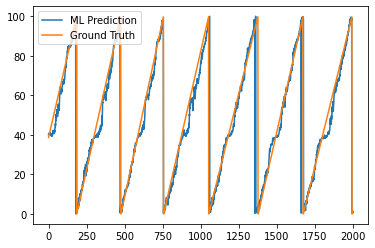

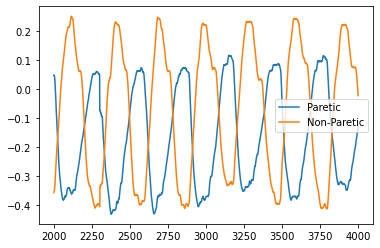

In [67]:
plt.plot(gp_pred_l[2000:4000], label = 'ML Prediction')
plt.plot(gp_true_l[2000:4000], label = 'Ground Truth')
plt.legend()
# plt.legend((gp_pred_l, gp_true_l), ('ML Predict', 'Ground Truth'))
plt.show()

plt.plot(data_list[0]['lJPos'][2000:4000], label = 'Paretic')
plt.plot(data_list[0]['rJPos'][2000:4000], label = 'Non-Paretic')
plt.legend()
plt.show()